# Introduction
> This notebook is a topic modeling analyse about tweets that mention the six biggest airline companies in the US. The goal is to extract the most commun topics and to interpret them with the sentiment that they are link to.

# Librairie

In [181]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm #progress bar
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm #progress bar

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords
import re, numpy as np, pandas as pd

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV

#!pip install tensorflow
#!pip install tensorflow_hub
#!pip install tensorflow_text
import pickle #to save serialized data
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bruguet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bruguet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruguet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Bruguet\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Bruguet\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
tqdm.pandas() 

# Some functions to pre process data

In [5]:
def ReviewProcessing(df):
    # remove non alphanumeric 
    df['text_cleaned'] = df.text.str.replace('[^a-zA-Z0-9 ]', '')
    # lowercase
    df.text_cleaned = df.text_cleaned.str.lower()
    # split into list
    df.text_cleaned = df.text_cleaned.str.split(' ')
    # remove stopwords
    df.text_cleaned = df.text_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
    return(df)

def LemProcessing(df):
    df['tokenize'] = df.text_cleaned_lemmatized.str.replace('[^a-zA-Z0-9 ]', '')
    # lowercase
    df.tokenize= df.tokenize.str.lower()
    # split into list
    df.tokenize = df.tokenize.str.split(' ')
    # remove stopwords
    df.tokenize = df.tokenize.apply(lambda x: [item for item in x if item not in stopwords_list])
    return(df)

In [6]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])

In [15]:
def remove_arobase(phrase, character_list):
    words = phrase.split()
    for word in words:
        if any(character in word for character in character_list):
            words.remove(word)
    new_phrase = ' '.join(words)
    return new_phrase

# Load data

In [8]:
tweet_path = os.path.join("..", "data", "Tweets.csv")
tweet = pd.read_csv(tweet_path)
#tweet = tweet.drop(['Unnamed: 0'],axis=1)
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Count the length of each tweet

In [141]:
df = tweet[['airline_sentiment','airline','text']]
df['text_length'] = df['text'].str.len()
df = df.dropna()
df.head()

<ipython-input-141-10d5c8fbc071>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].str.len()


,airline_sentiment,airline,text,text_length
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,35
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,72
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,71
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,126
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,55


## Pre process data

### Remove special caracters

In [142]:
df['original_text'] = df['text']
df['text'] = df['text'].apply(lambda x: remove_arobase(x, ['@', '#','http']))
df.head()

,airline_sentiment,airline,text,text_length,original_text
0,neutral,Virgin America,What said.,35,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,plus you've added commercials to the experienc...,72,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,I didn't today... Must mean I need to take ano...,71,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,"it's really aggressive to blast obnoxious ""ent...",126,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,and it's a really big bad thing about it,55,@VirginAmerica and it's a really big bad thing...


### Clean text (stop words)

In [143]:
# define stop words for this dataset
stopwords_list = stopwords.words('english')
stopwords_list.extend(['amp', #abreviation links to word such as 'F*ck'
                       #'flight','thanks', #Two words that occur the most but do not give sens to topics
                       'u','2','im','go','guy',
                      'should','could','would','get'
                      'thank','thanks']) # Words because of short way of writing
#stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [144]:
df = ReviewProcessing(df)
df.head()

<ipython-input-5-45c33ffb7bdb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_cleaned'] = df.text.str.replace('[^a-zA-Z0-9 ]', '')


,airline_sentiment,airline,text,text_length,original_text,text_cleaned
0,neutral,Virgin America,What said.,35,@VirginAmerica What @dhepburn said.,[said]
1,positive,Virgin America,plus you've added commercials to the experienc...,72,@VirginAmerica plus you've added commercials t...,"[plus, youve, added, commercials, experience, ..."
2,neutral,Virgin America,I didn't today... Must mean I need to take ano...,71,@VirginAmerica I didn't today... Must mean I n...,"[didnt, today, must, mean, need, take, another..."
3,negative,Virgin America,"it's really aggressive to blast obnoxious ""ent...",126,@VirginAmerica it's really aggressive to blast...,"[really, aggressive, blast, obnoxious, enterta..."
4,negative,Virgin America,and it's a really big bad thing about it,55,@VirginAmerica and it's a really big bad thing...,"[really, big, bad, thing]"


### Lemmatize

In [145]:
%%time
df.text_cleaned = df.text_cleaned.apply(' '.join)
df['text_cleaned_lemmatized'] = df.text_cleaned.apply(get_lemmatize)

Wall time: 3min 50s


In [146]:
df.head()

,airline_sentiment,airline,text,text_length,original_text,text_cleaned,text_cleaned_lemmatized
0,neutral,Virgin America,What said.,35,@VirginAmerica What @dhepburn said.,said,say
1,positive,Virgin America,plus you've added commercials to the experienc...,72,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky,plus youve add commercial experience tacky
2,neutral,Virgin America,I didn't today... Must mean I need to take ano...,71,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip,didnt today must mean need take another trip
3,negative,Virgin America,"it's really aggressive to blast obnoxious ""ent...",126,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,really aggressive blast obnoxious entertainmen...
4,negative,Virgin America,and it's a really big bad thing about it,55,@VirginAmerica and it's a really big bad thing...,really big bad thing,really big bad thing


### Tokenize and re sub spotword

In [147]:
df = LemProcessing(df)
df.head()

<ipython-input-5-45c33ffb7bdb>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tokenize'] = df.text_cleaned_lemmatized.str.replace('[^a-zA-Z0-9 ]', '')


,airline_sentiment,airline,text,text_length,original_text,text_cleaned,text_cleaned_lemmatized,tokenize
0,neutral,Virgin America,What said.,35,@VirginAmerica What @dhepburn said.,said,say,[say]
1,positive,Virgin America,plus you've added commercials to the experienc...,72,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky,plus youve add commercial experience tacky,"[plus, youve, add, commercial, experience, tacky]"
2,neutral,Virgin America,I didn't today... Must mean I need to take ano...,71,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip,didnt today must mean need take another trip,"[didnt, today, must, mean, need, take, another..."
3,negative,Virgin America,"it's really aggressive to blast obnoxious ""ent...",126,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,really aggressive blast obnoxious entertainmen...,"[really, aggressive, blast, obnoxious, enterta..."
4,negative,Virgin America,and it's a really big bad thing about it,55,@VirginAmerica and it's a really big bad thing...,really big bad thing,really big bad thing,"[really, big, bad, thing]"


In [84]:
#df['tokenized_text'] = df.apply(lambda row: nltk.word_tokenize(row['text_cleaned_lemmatized']), axis=1)
#df.head()

## Quick visualisation

### Tweet length distribution

Text(0.5, 1.0, 'Tweet Length Distribution')

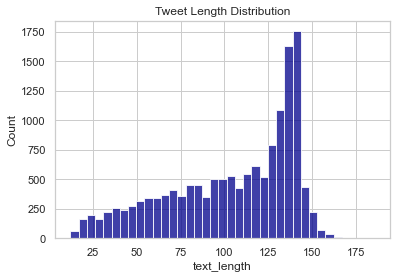

In [148]:
sns.histplot(data=df, x='text_length', bins='auto', color='darkblue');
plt.title('Tweet Length Distribution')

### Distribution of Sentiment Labels

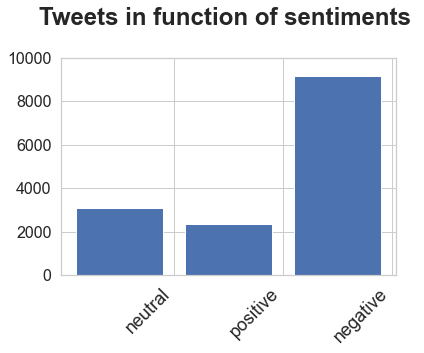

In [149]:
ax = plt.subplot(111)
sentCounts = dict(Counter(df['airline_sentiment']))
barPolt = plt.bar(range(len(sentCounts)),sentCounts.values())
plt.xticks([i+0.5 for i in range(len(sentCounts.keys()))],sentCounts.keys(),rotation=45,ha='right',fontsize=18)
ax.set_title('Tweets in function of sentiments \n',fontsize=24,fontweight='bold')
yTix = plt.yticks()[0]
plt.yticks(yTix,fontsize=16)
plt.show()

### Airline distribution

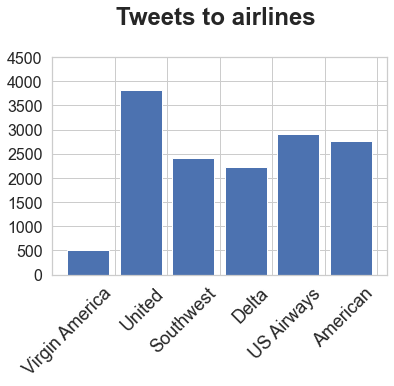

In [150]:
ax = plt.subplot(111)
airCounts = dict(Counter(df['airline']))
barPolt = plt.bar(range(len(airCounts)),airCounts.values())
plt.xticks([i+0.5 for i in range(len(airCounts.keys()))],airCounts.keys(),rotation=45,ha='right',fontsize=18)
ax.set_title('Tweets to airlines \n',fontsize=24,fontweight='bold')
yTix = plt.yticks()[0]
plt.yticks(yTix,fontsize=16)
plt.show()

### Part of sentiments for each airline

In [151]:
freq = pd.crosstab(columns=df['airline_sentiment'], 
                    index=df['airline'])\
.apply(lambda r: r/r.sum(), axis=1)\
.round(4)*100
freq ['Total'] = freq ['negative'] + freq ['neutral'] + freq ['positive']
freq 

airline_sentiment,negative,neutral,positive,Total
airline,,,,
American,71.04,16.78,12.18,100.0
Delta,42.98,32.54,24.48,100.0
Southwest,49.01,27.44,23.55,100.0
US Airways,77.69,13.08,9.23,100.0
United,68.89,18.24,12.87,100.0
Virgin America,35.91,33.93,30.16,100.0


In [154]:
print(f"Orignal Text : {df.original_text[100]}")
print()
print(f"Preprocessed Text : {df.text_cleaned_lemmatized[100]}")

Orignal Text : @VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM

Preprocessed Text : try add boy prince ressie sf thursday lax


In [155]:
df = df.dropna()
df.shape

(14640, 8)

## Creat dictionary and corpus to build LDA

In [ ]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [156]:
data_words = df["tokenize"]
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1)]


## Build LDA model

In [157]:
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [158]:
lda_model.print_topics()

[(0,
  '0.015*"flight" + 0.014*"get" + 0.011*"hour" + 0.009*"thank" + 0.009*"call" + 0.008*"time" + 0.007*"one" + 0.006*"please" + 0.006*"cancel" + 0.006*"want"'),
 (1,
  '0.063*"flight" + 0.017*"cancel" + 0.015*"get" + 0.012*"service" + 0.011*"customer" + 0.009*"call" + 0.007*"try" + 0.006*"hour" + 0.006*"need" + 0.006*"flightled"'),
 (2,
  '0.021*"get" + 0.018*"flight" + 0.011*"help" + 0.011*"plane" + 0.011*"hour" + 0.009*"wait" + 0.008*"need" + 0.008*"time" + 0.007*"bag" + 0.007*"make"'),
 (3,
  '0.032*"flight" + 0.013*"get" + 0.009*"help" + 0.009*"service" + 0.008*"call" + 0.008*"customer" + 0.007*"hour" + 0.007*"cancel" + 0.007*"take" + 0.006*"fly"')]

## Visualisation of LDA topics

### Definition of a function that create a clear df

In [159]:
from tqdm.notebook import tqdm #progress bar
def format_topics_sentences(ldamodel=None, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in tqdm(enumerate(ldamodel[corpus]), total =len(texts), desc = 'Progess ' ):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    return(sent_topics_df)

In [160]:
#Use the function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)

Progess :   0%|          | 0/14640 [00:00<?, ?it/s]

In [161]:
df_dominant_topic = df_topic_sents_keywords.copy()

In [162]:
# Format
#airline = df.airline
# Add original text to the end of the output
df_dominant_topic = pd.concat([df_dominant_topic, df.text], axis=1)
# Add sentiment
df_dominant_topic = pd.concat([df_dominant_topic, df.airline_sentiment], axis=1)
# Add airline
df_dominant_topic = pd.concat([df_dominant_topic, df.airline],axis=1)
df_dominant_topic = df_dominant_topic.reset_index()

df_dominant_topic.columns = ['Document_No',
                             'Dominant_Topic',
                             'Topic_Perc_Contrib', 
                             'Keywords',
                             'Text',
                             'Sentiment',
                             'Airline']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Sentiment,Airline
0,0,1.0,0.5883,"flight, cancel, get, service, customer, call, ...",What said.,neutral,Virgin America
1,1,2.0,0.8866,"get, flight, help, plane, hour, wait, need, ti...",plus you've added commercials to the experienc...,positive,Virgin America
2,2,2.0,0.5877,"get, flight, help, plane, hour, wait, need, ti...",I didn't today... Must mean I need to take ano...,neutral,Virgin America
3,3,0.0,0.9175,"flight, get, hour, thank, call, time, one, ple...","it's really aggressive to blast obnoxious ""ent...",negative,Virgin America
4,4,1.0,0.8386,"flight, cancel, get, service, customer, call, ...",and it's a really big bad thing about it,negative,Virgin America
5,5,3.0,0.8626,"flight, get, help, service, call, customer, ho...",seriously would pay $30 a flight for seats tha...,negative,Virgin America
6,6,0.0,0.9283,"flight, get, hour, thank, call, time, one, ple...","yes, nearly every time I fly VX this “ear worm...",positive,Virgin America
7,7,0.0,0.9098,"flight, get, hour, thank, call, time, one, ple...",Really missed a prime opportunity for Men With...,neutral,Virgin America
8,8,0.0,0.7435,"flight, get, hour, thank, call, time, one, ple...","Well, I didn't…but NOW I DO! :-D",positive,Virgin America
9,9,3.0,0.6240,"flight, get, help, service, call, customer, ho...","it was amazing, and arrived an hour early. You...",positive,Virgin America


In [163]:
from collections import Counter
K=range(0,4)
for k in K:
    df_cluster = df_dominant_topic[df_dominant_topic.Dominant_Topic == k]
    cluster = df_cluster.Keywords
    count = Counter(cluster)
    topic = count.most_common(10)
    print("topic%d:"% k , topic, "\n")

topic0: [('flight, get, hour, thank, call, time, one, please, cancel, want', 3122)] 

topic1: [('flight, cancel, get, service, customer, call, try, hour, need, flightled', 4139)] 

topic2: [('get, flight, help, plane, hour, wait, need, time, bag, make', 3369)] 

topic3: [('flight, get, help, service, call, customer, hour, cancel, take, fly', 4010)] 



> The four topics seem to be the following ones :
- Topic 0 : Flight cancel, need to call (the service customer) OR want to cancel the flight
- Topic 1 : Try to call the customer service for hour, need to cancel the flight
- Topic 2 : Need help to get (get = récupérer) a bag , wait for hours
- Topic 3 : Customer cancel flight (encore??)

In [164]:
freq = pd.crosstab(columns=df_dominant_topic['Sentiment'], 
                    index=df_dominant_topic['Dominant_Topic'])\
.apply(lambda r: r/r.sum(), axis=1)\
.round(4)*100
freq ['Total'] = freq ['negative'] + freq ['neutral'] + freq ['positive']
freq 

Sentiment,negative,neutral,positive,Total
Dominant_Topic,,,,
0.0,54.45,24.22,21.33,100.00
1.0,65.76,20.68,13.55,99.99
2.0,63.16,21.85,14.99,100.00
3.0,65.54,18.73,15.74,100.01


In [165]:
freq = pd.crosstab(columns=df_dominant_topic['Dominant_Topic'], 
                    index=df_dominant_topic['Airline'])\
.apply(lambda r: r/r.sum(), axis=1)\
.round(4)*100
#freq ['Total'] = freq ['American'] + freq ['Delta'] + freq['Southwest'] + freq ['US Airways'] + freq['United']+freq['Virgin America']
freq 

Dominant_Topic,0.0,1.0,2.0,3.0
Airline,,,,
American,22.07,29.61,23.67,24.65
Delta,23.09,26.69,19.17,31.05
Southwest,21.16,29.34,24.21,25.29
US Airways,20.01,27.94,22.97,29.08
United,21.01,27.52,23.97,27.50
Virgin America,20.24,30.36,23.61,25.79


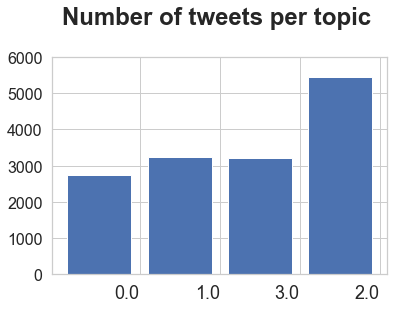

2.0    5450
1.0    3227
3.0    3215
0.0    2748
Name: Dominant_Topic, dtype: int64


In [101]:
ax = plt.subplot(111)
Counts = dict(Counter(df_dominant_topic['Dominant_Topic']))
barPolt = plt.bar(range(len(Counts)),Counts.values())
plt.xticks([i+0.5 for i in range(len(Counts.keys()))],Counts.keys(),ha='right',fontsize=18)
ax.set_title('Number of tweets per topic \n',fontsize=24,fontweight='bold')
yTix = plt.yticks()[0]
plt.yticks(yTix,fontsize=16)
plt.show()
print(df_dominant_topic['Dominant_Topic'].value_counts())

## Wordcloud

In [102]:
# Import the wordcloud library
#!pip install wordcloud
from wordcloud import WordCloud

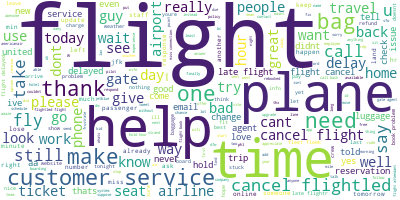

In [190]:
# Join the different processed titles together.
long_string = ','.join(list(df['text_cleaned_lemmatized'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Wordcloud per topic

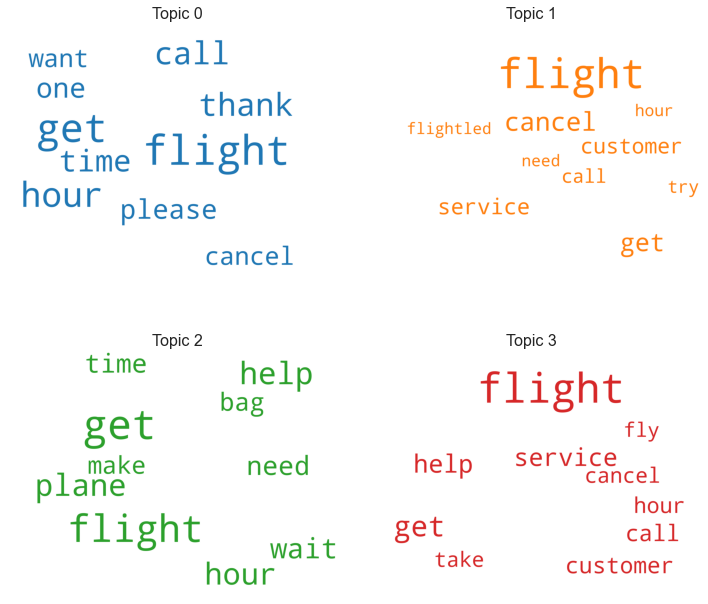

In [191]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.colors as mcolors
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2,2 , figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Use clustering to toping modeling 

In [106]:
#!pip install tensorflow
#!pip install tensorflow_hub
#!pip install tensorflow_text
import pickle #to save serialized data
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_text
import numpy as np

In [124]:
#embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [125]:
def use_vectorize(texts, chunk_size=1000) -> np.ndarray:
        embedder = embed
        if len(texts) <= chunk_size:
            return embedder(texts).numpy().astype(np.float16)
            #return embedder(texts).numpy()
        res = []
        for i in tqdm(range(0, len(texts), chunk_size), total=round(len(texts)/chunk_size), desc="Vectorization"):
            cu_texts = texts[i:i+chunk_size]
            res.append(embedder(cu_texts).numpy().astype(np.float16))
            #res.append(embedder(cu_texts).numpy())
        return np.concatenate(res)

In [167]:
embeddings = use_vectorize(df['text_cleaned_lemmatized'].astype(str).tolist())
pickle_out = open("embeddings.p","wb")
pickle.dump(embeddings, pickle_out)
pickle_out.close()

Vectorization:   0%|          | 0/15 [00:00<?, ?it/s]

In [168]:
embeddings.shape

(14640, 512)

## Use PCA to reduce the dimension

In [111]:
from sklearn.decomposition import PCA #PCA
from sklearn.cluster import KMeans, DBSCAN #clustering methods

In [112]:
def pca(message_embeddings):
    pca = PCA(0.6)
    newX = pca.fit_transform(message_embeddings)
    newdf = pd.DataFrame(newX)
    newdf.to_pickle('pca.p')
    return (newdf)

In [169]:
df_embed = pca(embeddings)
df_embed.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.517921,0.178403,0.074392,0.267920,0.018855,0.118117,0.002728,-0.103517,0.007130,0.016053,...,0.091650,0.032058,0.076866,-0.095746,0.052829,0.009760,0.006120,-0.034259,0.034761,-0.045773
1,0.156770,-0.093112,-0.210951,-0.058237,0.077877,-0.095368,0.036225,0.118419,-0.007127,-0.079539,...,0.025711,0.073258,-0.067523,0.033589,0.060509,0.024865,0.053936,-0.033532,0.051948,0.040219
2,0.062293,-0.024937,0.045873,-0.009522,-0.166364,-0.307054,0.104844,-0.115082,0.081741,-0.061270,...,0.038686,-0.105212,0.025829,0.079418,0.092867,0.078333,-0.149635,-0.050875,-0.036483,0.053891
3,0.005750,-0.214535,-0.200948,-0.058312,0.193500,0.009968,0.044612,-0.075095,-0.021485,-0.071600,...,-0.001862,0.032575,-0.007597,-0.004689,0.034590,0.000053,0.056813,-0.017911,-0.033630,0.050192
4,0.313043,0.029060,-0.149722,-0.040980,0.278769,-0.013789,0.140248,-0.229981,-0.042799,-0.032048,...,0.012342,-0.007472,-0.074942,0.009441,-0.009356,0.020910,-0.083969,0.022499,-0.056731,-0.027773


In [170]:
df_embed.shape

(14640, 70)

## Use K-Means to cluster topics

### Use the elbow method to define the k clusters
> the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. 

In [185]:
K = range(1,20)
SSE = []
for k in tqdm(K, total = len(K)):
    clustering = KMeans(n_clusters = k)
    clustering.fit(df_embed.values.astype(float))
    SSE.append(clustering.inertia_)

  0%|          | 0/19 [00:00<?, ?it/s]

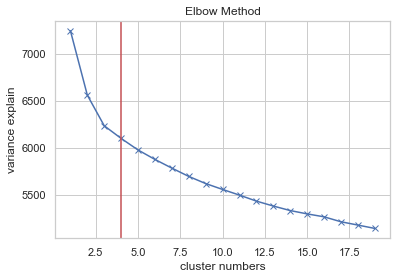

In [189]:
import matplotlib.pyplot as plt
plt.plot(K,SSE,'bx-')
plt.title('Elbow Method')
plt.xlabel('cluster numbers')
plt.ylabel('variance explain')
plt.axvline(x = 4, c='r')
plt.show()

### Use kmeans

In [176]:
clustering = KMeans(n_clusters=4).fit(df_embed.values.astype(float))

In [177]:
df['Cluster'] = clustering.labels_

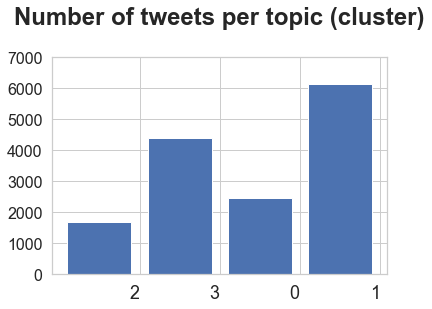

1    6141
3    4372
0    2450
2    1677
Name: Cluster, dtype: int64


In [178]:
ax = plt.subplot(111)
Counts = dict(Counter(df['Cluster']))
barPolt = plt.bar(range(len(Counts)),Counts.values())
plt.xticks([i+0.5 for i in range(len(Counts.keys()))],Counts.keys(),ha='right',fontsize=18)
ax.set_title('Number of tweets per topic (cluster)\n',fontsize=24,fontweight='bold')
yTix = plt.yticks()[0]
plt.yticks(yTix,fontsize=16)
plt.show()
print(df['Cluster'].value_counts())

### Understanding of the topics

In [179]:
K=range(0,4)
for k in K:
    df_cluster = df[df.Cluster == k]
    cluster = df_cluster.tokenize.explode().tolist()
    count = Counter(cluster)
    topic = count.most_common(10)
    print("cluster%d:"% k , topic, "\n")
#AJOUTER CHAQUE TOPIC COMME COLUM DANS UN DF POUR MEILLEUR LISIBILITE

cluster0: [('customer', 681), ('service', 640), ('call', 468), ('get', 450), ('hour', 337), ('hold', 300), ('phone', 277), ('wait', 273), ('help', 248), ('time', 224)] 

cluster1: [('flight', 4739), ('cancel', 1047), ('get', 1011), ('plane', 705), ('hour', 646), ('fly', 583), ('airline', 542), ('time', 530), ('flightled', 501), ('delayed', 419)] 

cluster2: [('thank', 220), ('dm', 93), ('', 88), ('fleek', 82), ('fleet', 81), ('follow', 72), ('get', 65), ('sent', 55), ('please', 47), ('help', 40)] 

cluster3: [('get', 567), ('bag', 297), ('help', 231), ('make', 222), ('need', 197), ('seat', 194), ('please', 189), ('one', 189), ('thank', 182), ('like', 179)] 



> The four topics seem to be the following ones :
- Cluster 0 :  Hold for a long time when calling the customer service
- Cluster 1 : Flighted from the airline about cancelation, delayed and hours
- Cluster 2 : Need help to follow the fleek leading to the right fleet
- Cluster 3 : Need help for a bag or a seat, more polite topics (like as in would like , please, thank)

In [194]:
freq = pd.crosstab(columns=df['airline_sentiment'], 
                    index=df['Cluster'])\
.apply(lambda r: r/r.sum(), axis=1)\
.round(4)*100
freq ['Total'] = freq ['negative'] + freq ['neutral'] + freq ['positive']
freq 

airline_sentiment,negative,neutral,positive,Total
Cluster,,,,
0,85.88,6.08,8.04,100.0
1,71.73,17.08,11.19,100.0
2,24.15,39.36,36.49,100.0
3,51.78,28.39,19.83,100.0


In [195]:
freq = pd.crosstab(columns=df['Cluster'], 
                    index=df['airline'])\
.apply(lambda r: r/r.sum(), axis=1)\
.round(4)*100
#freq ['Total'] = freq ['American'] + freq ['Delta'] + freq['Southwest'] + freq ['US Airways'] + freq['United']+freq['Virgin America']
freq 

Cluster,0,1,2,3
airline,,,,
American,22.18,42.52,9.42,25.88
Delta,8.46,36.50,18.59,36.45
Southwest,12.60,40.45,13.10,33.84
US Airways,21.73,45.35,7.59,25.33
United,17.32,43.62,10.49,28.57
Virgin America,9.92,37.70,12.90,39.48


# Marketing insight

Need to have a better relation with customer, all topics are negative.
Use the topics to focus on particular fiel to update such as lost of luggage, hotline respons, cancellation and delay.

# To improve

- Still some words that do not have much sens in the topic, such as get. Maybe use a better librairie or a pre trained neural network
- The choice of the number of topics, use of GridSearc with LDA from the SKLEARN librairie
- Use Trigram and Bigram
> N - grams are N words frequently occurring together in the document. It allows to have a better quality of topics, clearer , segregated and meaningful